# Baseline Model Colab
BASELINE MODEL COLAB: https://colab.research.google.com/drive/1gZAlhUvILJkA7cA5WpvI0uU_oj2tzLKx

# Primary Model Colab

In [1]:
#install appropriate packages and libraries
!pip install opendatasets
!pip install pandas
!pip install torch torchvision
!pip install torch==1.11.0+cu102 torchvision==0.12.0+cu102 -f

import opendatasets as od
import pandas
import math
import pandas as pd #redundant -- remove
import numpy as np
from sklearn import svm
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
from PIL import Image

#is cuda available?
use_cuda = torch.cuda.is_available()

from google.colab import drive
drive.mount('/content/gdrive')


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-f option requires 1 argument
Mounted at /content/gdrive


In [2]:
# Path to data for Jo (do not delete)
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive/UofT/EngSci/Year 4/Intro to ML (APS360)/APS360 Project/datasets')
os.listdir()

Mounted at /content/drive


['test.csv',
 'train.csv',
 'correct_dir',
 'incorrect_dir',
 'train',
 '.ipynb_checkpoints',
 'model_resnet_2_bs128_lr0.001_epoch20_train_acc.csv',
 'model_resnet_2_bs128_lr0.001_epoch20_train_loss.csv',
 'model_resnet_2_bs128_lr0.001_epoch20_train_error.csv',
 'model_resnet_2_bs128_lr0.001_epoch20_val_acc.csv',
 'model_resnet_2_bs128_lr0.001_epoch20_val_loss.csv',
 'model_resnet_2_bs128_lr0.001_epoch20_val_error.csv',
 'resnet_2best_model_params.pt',
 'resnet1best_model_params.pt',
 'model_resnet_2_bs128_lr0.001_epoch10_train_loss.csv',
 'model_resnet_2_bs128_lr0.001_epoch10_train_acc.csv',
 'model_resnet_2_bs128_lr0.001_epoch10_train_error.csv',
 'model_resnet_2_bs128_lr0.001_epoch10_val_error.csv',
 'model_resnet_2_bs128_lr0.001_epoch10_val_acc.csv',
 'model_resnet_2_bs128_lr0.001_epoch10_val_loss.csv',
 'incorrect_dir2',
 'correct_dir2',
 'pretrained_resnet4best_model_params.pt',
 'model_pretrained_resnet4_bs128_lr0.0001_epoch20best_model_params.pt',
 'model_pretrained_resnet4_bs1

In [ ]:
# Path to data (do not delete)
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive/APS360Project/datasets')
os.listdir()

In [3]:
# helper functions
def save_model_classifications(model, dataloader, correct_dir="correct_dir", incorrect_dir="incorrect_dir"):
  class_names = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}
  img_num = 0

  for batch in dataloader:
    inputs = batch[0]
    labels = batch[1]

    if use_cuda:
      inputs, labels = inputs.cuda(), labels.cuda()

    inputs, labels = Variable(inputs), Variable(labels)

    # get predictions
    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)

    for i in range(len(preds)):
      pred = class_names[int(preds[i])]
      act = class_names[int(labels[i])]
      img = inputs[i]
      img_num += 1

      # save correct images into folder
      if (pred == act):
        save_image(img, pred, act, correct_dir, img_num)

      # save incorrect images into folder
      else:
        save_image(img, pred, act, incorrect_dir, img_num)


def save_image(image, predicted_label, actual_label, dir, img_num):
  name = "{}/PRED_{}_ACT_{}_num_{}.jpg".format(dir, predicted_label, actual_label, img_num)
  if use_cuda:
    image = image.cpu()
  inp = image.numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  plt.savefig(name)
  #plt.imshow(inp)
  #transform = transforms.ToPILImage()
  #img = transform(image)
  #img.show()
  #img.save(name)


In [4]:
# Training Curve
# Validation commented out right now

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    val_err = np.loadtxt("{}_val_error.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    train_err = np.loadtxt("{}_train_error.csv".format(path))
    n = len(train_loss) # number of epochs
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Error")
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    plt.title("Accuracy")
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.legend(loc='best')
    plt.show()

# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def get_category_recall(model, loader):
  total_samples = {'Angry':0.0, 'Disgust':0.0, 'Fear':0.0, 'Happy':0.0, 'Neutral':0.0, 'Sad':0.0, 'Surprise':0.0}
  correct_samples = {'Angry':0.0, 'Disgust':0.0, 'Fear':0.0, 'Happy':0.0, 'Neutral':0.0, 'Sad':0.0, 'Surprise':0.0}
  class_names = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}

  for batch in loader:
      inputs = batch[0]
      labels = batch[1]

      if use_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()

      outputs = model(inputs)
      _, preds = torch.max(outputs.data, 1)

      # statistics
      for i in range(len(preds)):
        total_samples[class_names[int(labels[i])]] += 1.0

        if (preds[i] == labels[i]):
          correct_samples[class_names[int(preds[i])]] += 1.0

  print(total_samples, correct_samples)
  for key, value in total_samples.items():
    if (total_samples[key]): correct_samples[key] = correct_samples[key]/total_samples[key]

  return correct_samples

def get_category_precision(model, loader):
  total_predictions = {'Angry':0.0, 'Disgust':0.0, 'Fear':0.0, 'Happy':0.0, 'Neutral':0.0, 'Sad':0.0, 'Surprise':0.0}
  correct_predictions = {'Angry':0.0, 'Disgust':0.0, 'Fear':0.0, 'Happy':0.0, 'Neutral':0.0, 'Sad':0.0, 'Surprise':0.0}
  class_names = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}

  for batch in loader:
      inputs = batch[0]
      labels = batch[1]

      if use_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()

      outputs = model(inputs)
      _, preds = torch.max(outputs.data, 1)

      # statistics
      for i in range(len(preds)):
        total_predictions[class_names[int(preds[i])]] += 1.0

        if (preds[i] == labels[i]):
          correct_predictions[class_names[int(preds[i])]] += 1.0

  print(total_predictions, correct_predictions)
  for key, value in total_predictions.items():
    if (total_predictions[key]): correct_predictions[key] = correct_predictions[key]/total_predictions[key]

  return correct_predictions

def get_loss_accuracy(model, loader):
  batch_idx = 0
  running_loss = 0
  running_corrects = 0
  total_images = 0

  for batch in loader:
      # loader is a list of batches where each batch contains 2 tensors- inputs and it's associated labels of size batch_size
      batch_idx+=1
      inputs = batch[0]
      labels = batch[1]

      if use_cuda:
        inputs, labels = inputs.cuda(), labels.cuda()

      outputs = model(inputs)
      _, preds = torch.max(outputs.data, 1)
      loss = criterion(outputs, labels)

      # statistics
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data)
      total_images += labels.size(0)

  loss = running_loss / (batch_idx+1)
  acc = 100.0 * running_corrects / total_images

  return loss, acc

In [5]:
'''
New data processing that gets actual images from APS360Project/archive/train
They are organized according to the emotions inside the folders and this code
automatically makes those into labels
We have a test set as well but we didnt import it here.
Train can be split into 30% validation here. I think ImageFolder/Dataloader library has a way to do that automatically
'''

# Data augmentation and normalization for training
# Just normalization if we have validation set
# Can add more tranformations here as well
# We found that these numbers for resize and Normalize work best for our dataset
# Checked it by printing out the images
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
    ]),
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# Gets the images from train folder and performs the transforms that are above
data_dir = ''
image_datasets = datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"])
train_set, val_set = torch.utils.data.random_split(image_datasets, [0.7, 0.3])
## do more transformations to train set here
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)
class_names = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


'''
This is some code to display the images in a grid
'''
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_set))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#imshow(out, title=[class_names[x] for x in classes])

#commented out, shows the img after transformations
#inputs, classes = next(iter(train_loader))
#class_label = class_names[classes[0].item()]
#imshow(inputs[0], title=f'Class: {class_label}')


In [6]:
'''
This is the code to perform all the training
Right now we just use train_loader to train but we should probably pass in the dataset we want to train since it can be validation too
Or just copy paste code to train on validation set...
'''

from tempfile import TemporaryDirectory
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# This is our data, use it inside train_model
# train_loader = dataloaders['train']
dataset_sizes = {
    'train': len(train_loader),
    'val': len(val_loader)
}

# I'm not entirely sure what this does but saw other people use it in training...
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            param.grad.data.clamp_(-grad_clip, grad_clip)

def train_model(model, model_path, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        # stores the training loss at every epoch
        train_loss = np.zeros(num_epochs)
        train_acc = np.zeros(num_epochs)
        train_error = np.zeros(num_epochs)

        # val loss
        val_loss = np.zeros(num_epochs)
        val_acc = np.zeros(num_epochs)
        val_error = np.zeros(num_epochs)

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    loader = train_loader
                else:
                    model.eval()   # Set model to evaluate mode
                    loader = val_loader

                running_loss = 0.0
                running_corrects = 0.0
                batch_idx = 0
                total_images = 0.0


                for batch in loader:
                  # loader is a list of batches where each batch contains 2 tensors- inputs and it's associated labels of size batch_size
                  batch_idx+=1
                  inputs = batch[0]
                  labels = batch[1]

                  if use_cuda:
                    inputs, labels = inputs.cuda(), labels.cuda()

                  # zero the parameter gradients
                  optimizer.zero_grad()
                  inputs, labels = Variable(inputs), Variable(labels)

                  # forward
                  # track history if only in train
                  if phase == 'train':
                    with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      _, preds = torch.max(outputs.data, 1)
                      loss = criterion(outputs, labels)

                      # backward + optimize only if in training phase
                      loss.backward()
                      clip_gradient(optimizer, 0.1)
                      optimizer.step()

                      # statistics
                      running_loss += loss.item()
                      running_corrects += torch.sum(preds == labels.data)
                      total_images += labels.size(0)
                      print('\nRunning Train Loss: ' + str(running_loss))

                  if phase == 'val':
                    with torch.set_grad_enabled(False):
                      outputs = model(inputs)
                      _, preds = torch.max(outputs.data, 1)
                      loss = criterion(outputs, labels)

                      # statistics
                      running_loss += loss.item()
                      running_corrects += torch.sum(preds == labels.data)
                      total_images += labels.size(0)
                      print('\nRunning Val Loss: ' + str(running_loss))

                epoch_loss = running_loss / (batch_idx+1)
                epoch_acc = 100.0 * running_corrects / total_images

                if phase == 'train':
                  train_loss[epoch] = epoch_loss
                  train_acc[epoch] = epoch_acc
                  train_error[epoch] = 100.0 - epoch_acc
                  scheduler.step()

                if phase == 'val':
                  val_loss[epoch] = epoch_loss
                  val_acc[epoch] = epoch_acc
                  val_error[epoch] = 100.0 - epoch_acc

                  if (epoch_acc > best_acc):
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        torch.save(model.state_dict(), model_path+"best_model_params.pt")

        # Write the train loss/err into CSV file for plotting later
        np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
        np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
        np.savetxt("{}_train_error.csv".format(model_path), train_error)

        # Write the val loss/err into CSV file for plotting later
        np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
        np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
        np.savetxt("{}_val_error.csv".format(model_path), val_error)

    return model

# model helper functions

In [7]:
class CustomBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(CustomBasicBlock, self).__init__()

        # Customize your block as needed
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.dropout = nn.Dropout2d(0.5)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.dropout(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        #out = self.dropout(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
            out += identity

        #out += identity
        out = self.relu(out)

        return out

def load_pretrained_model(path):
  # to load the model (saved in our drive)
  model = torchvision.models.resnet.resnet18(pretrained=False)

  output_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
  num_classes = len(output_classes)
  num_ftrs = model.fc.in_features

  model.fc =  nn.Sequential(
      nn.Linear(num_ftrs, 300),  # Add a classifier
      nn.ReLU(),
      nn.Linear(300, 200),  # sizes are arbitrary right now
      nn.ReLU(),
      nn.Linear(200, num_classes)
  )

  downsample = nn.Sequential(
      nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False),
      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))

  model.layer4 = nn.Sequential(
      CustomBasicBlock(in_channels=256, out_channels=512, stride=2, downsample=downsample),
      CustomBasicBlock(in_channels=512, out_channels=512, stride=1))

  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
  return model

In [8]:
from IPython.display import HTML

def get_model_output (model, loader):
  batch = next(iter(loader))
  inputs = batch[0]
  outputs = model(inputs)
  _, preds = torch.max(outputs.data, 1)
  return inputs, preds

def disp_output(pred):
  class_names = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}
  emotion_to_emoji = {
    "Angry": "😡",
    "Disgust": "🤢",
    "Fear": "😨",
    "Happy": "😁",
    "Sad": "🙁",
    "Surprise": "😮",
    "Neutral": "😐"
  }
  emotion = class_names[int(pred)]
  out = emotion_to_emoji[emotion]
  display(HTML(f"<p style='font-size: 200px;'>{out}</p>"))

def display_image(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)


# DEMO

STEP 1: Load the model

In [9]:
pretrained_resnet = load_pretrained_model("pretrained_resnet4best_model_params.pt")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


STEP 2: Load the data and apply transforms

In [10]:
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        transforms.Grayscale(num_output_channels=3)
    ])
}

# Gets the images from train folder and performs the transforms that are above
data_dir = ''
demo_set = datasets.ImageFolder(os.path.join(data_dir, "demo"), data_transforms["test"])
demo_loader = torch.utils.data.DataLoader(demo_set, batch_size=128, shuffle=False, num_workers=2)

STEP 3: Make predictions

In [11]:
inputs, preds = get_model_output(pretrained_resnet, demo_loader)

STEP 4: Display predictions

predicted emotion: Neutral
--------------------------------

predicted emoji:


--------------------------------
INPUT:


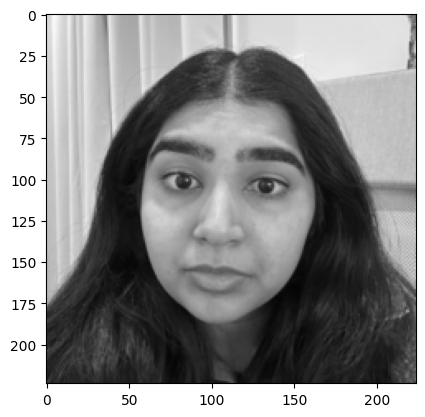

In [48]:
i = np.random.randint(35)
class_names = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}
print("predicted emotion:", class_names[int(preds[i])])
display_image(inputs[i])

print("--------------------------------\n\npredicted emoji:")
disp_output(preds[i])
print("--------------------------------\nINPUT:")

# MODEL V4
*   dropout in layer4
*   layer4 and FC layers unfrozen
*   weight decay used

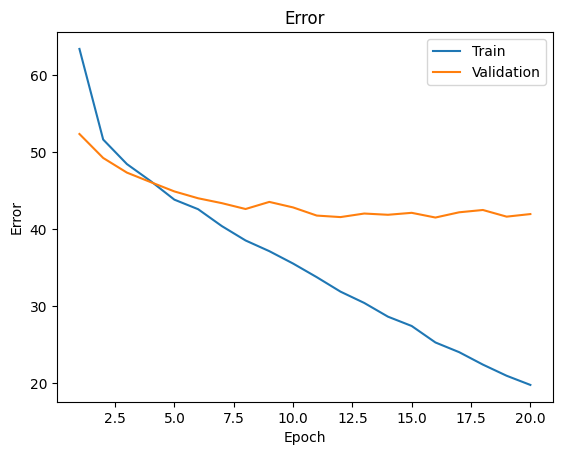

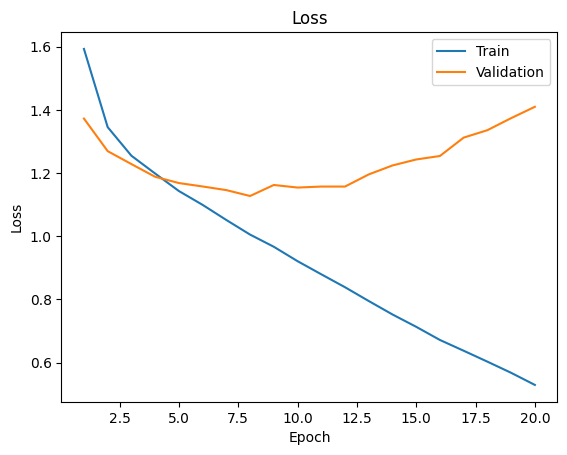

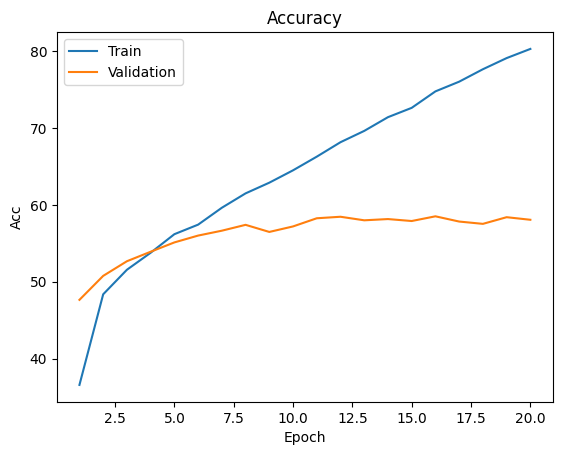

In [ ]:
model_path4 = get_model_name("pretrained_resnet4", batch_size=128, learning_rate=0.0001, epoch=20) # add "with_transformations" if re-training
plot_training_curve(model_path4)

In [ ]:
# Step 1: Load the pre-trained ResNet model
pretrained_resnet = torchvision.models.resnet18(pretrained=True)
num_ftrs = pretrained_resnet.fc.in_features
output_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_classes = len(output_classes)

# Step 2: add new classification layer layers
pretrained_resnet.fc =  nn.Sequential(
    nn.Linear(num_ftrs, 300),  # Add a classifier
    nn.ReLU(),
    nn.Linear(300, 200),  # sizes are arbitrary right now
    nn.ReLU(),
    nn.Linear(200, num_classes)
)

# Step 3: Build custom block
downsample = nn.Sequential(
    nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))

new_layer4 = nn.Sequential(
    CustomBasicBlock(in_channels=256, out_channels=512, stride=2, downsample=downsample),
    CustomBasicBlock(in_channels=512, out_channels=512, stride=1))
pretrained_resnet.layer4 =  new_layer4

print("CUSTOM\n\n\n", pretrained_resnet)

# Step 4: Train the model
if use_cuda:
  pretrained_resnet = pretrained_resnet.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Step 5: Freeze the ResNet-18 weights and biases. Unfreeze the final (4th) layer and final layer for fine-tuning.
for name, param in pretrained_resnet.named_parameters():
  if ("fc" in name) or ("4" in name):
    param.requires_grad = True
  else:
    param.requires_grad = False
  print(param.requires_grad, name)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, pretrained_resnet.parameters()), lr=0.0001, betas=(0.9, 0.999), eps=1e-7, weight_decay=5e-4)
# using weight decay, low learning rate to mitigate overfitting

model_path4_wtransf = get_model_name("pretrained_resnet4", batch_size=128, learning_rate=0.0001, epoch=20) # add "with_transformations" if re-training
# model_path4_tranforms = get_model_name("pretrained_resnet4_transforms", batch_size=128, learning_rate=0.0001, epoch=20)

# Step 6: Train the model
pretrained_resnet = train_model(pretrained_resnet, model_path4_wtransf, criterion, optimizer, optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
                       num_epochs=20)

plot_training_curve(model_path4_wtransf)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
 90%|█████████ | 40.4M/44.7M [00:01<00:00, 23.3MB/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-9b593cae7862>", line 2, in <cell line: 2>
    pretrained_resnet = torchvision.models.resnet18(pretrained=True)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py", line 142, in wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py", line 228, in inner_wrapper
    return builder(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/models/resnet.py", line 705, in resnet18
    return _resnet(BasicBlock, [2, 2, 2, 2], weights, progress, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/models/resnet.py", line 301, in _resnet
    model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))
  File "/usr/local/lib/python3.10/

In [ ]:
# to load the model (saved in our drive)
pretrained_resnet = torchvision.models.resnet.resnet18(pretrained=False)

output_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_classes = len(output_classes)
num_ftrs = pretrained_resnet.fc.in_features

pretrained_resnet.fc =  nn.Sequential(
    nn.Linear(num_ftrs, 300),  # Add a classifier
    nn.ReLU(),
    nn.Linear(300, 200),  # sizes are arbitrary right now
    nn.ReLU(),
    nn.Linear(200, num_classes)
)

downsample = nn.Sequential(
    nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))

pretrained_resnet.layer4 = nn.Sequential(
    CustomBasicBlock(in_channels=256, out_channels=512, stride=2, downsample=downsample),
    CustomBasicBlock(in_channels=512, out_channels=512, stride=1))

pretrained_resnet.load_state_dict(torch.load("pretrained_resnet4best_model_params.pt", map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
get_category_precision(pretrained_resnet, val_loader)

{'Angry': 1620.0, 'Disgust': 0.0, 'Fear': 1020.0, 'Happy': 2502.0, 'Neutral': 1409.0, 'Sad': 1400.0, 'Surprise': 718.0} {'Angry': 444.0, 'Disgust': 0.0, 'Fear': 271.0, 'Happy': 1495.0, 'Neutral': 515.0, 'Sad': 440.0, 'Surprise': 422.0}


{'Angry': 0.2740740740740741,
 'Disgust': 0.0,
 'Fear': 0.2656862745098039,
 'Happy': 0.5975219824140687,
 'Neutral': 0.36550745209368346,
 'Sad': 0.3142857142857143,
 'Surprise': 0.5877437325905293}

In [ ]:
get_category_acc(pretrained_resnet, val_loader)

In [ ]:
save_model_classifications(pretrained_resnet, val_loader, correct_dir="correct_dir", incorrect_dir="incorrect_dir")

In [ ]:
os.listdir()

In [ ]:
# GET TEST ACCURACY
data_dir = ''
test_set = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms["test"])
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
class_names = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}
criterion = nn.CrossEntropyLoss()

get_loss_accuracy(pretrained_resnet, test_loader)

(2.8179765508092682, tensor(21.3012))

In [ ]:
get_loss_accuracy(pretrained_resnet, val_loader)

In [ ]:
print(pretrained_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
save_model_classifications(pretrained_resnet, test_loader, correct_dir="correct_dir", incorrect_dir="incorrect_dir")

In [ ]:
print(loss, acc)

# MODEL V3

*   only FC layers unfrozen
*   weight decay used

In [ ]:
'''
Code for initializing primary model- resnet18
'''

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim # for gradient descent
import torchvision.models

torch.manual_seed(1) # set the random seed

# obtain data
from torchvision import datasets, transforms

# Step 1: define model
resnet3 = torchvision.models.resnet.resnet18(pretrained=True)

# Step 2: Modify the classifier
output_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_classes = len(output_classes)

num_ftrs = resnet3.fc.in_features
resnet3.fc = nn.Sequential(
    nn.Linear(num_ftrs, 300),  # Add a classifier
    nn.ReLU(),
    nn.Linear(300, 200),  # sizes are arbitrary right now
    nn.ReLU(),
    nn.Linear(200, num_classes)
)

# Step 3: Freeze the ResNet-18 weights and biases. Unfreeze the final (4th) layer and final layer for fine-tuning.
for name, param in resnet3.named_parameters():
  if ("fc" in name):
    param.requires_grad = True
  else:
    param.requires_grad = False
  print(param.requires_grad, name)

if use_cuda:
  resnet3 = resnet3.cuda()
  resnet3.fc = resnet3.fc.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Step 4: Define loss function and optimizer
# Can play around with parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet3.parameters()), lr=0.0001, betas=(0.9, 0.999), eps=1e-7, weight_decay=5e-4)
# using weight decay, low learning rate to mitigate overfitting

model_path3 = get_model_name("resnet3", batch_size=128, learning_rate=0.0001, epoch=10)

# Step 5: Train the model
resnet3 = train_model(resnet3, "resnet3", criterion, optimizer, optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
                       num_epochs=10)

False conv1.weight
False bn1.weight
False bn1.bias
False layer1.0.conv1.weight
False layer1.0.bn1.weight
False layer1.0.bn1.bias
False layer1.0.conv2.weight
False layer1.0.bn2.weight
False layer1.0.bn2.bias
False layer1.1.conv1.weight
False layer1.1.bn1.weight
False layer1.1.bn1.bias
False layer1.1.conv2.weight
False layer1.1.bn2.weight
False layer1.1.bn2.bias
False layer2.0.conv1.weight
False layer2.0.bn1.weight
False layer2.0.bn1.bias
False layer2.0.conv2.weight
False layer2.0.bn2.weight
False layer2.0.bn2.bias
False layer2.0.downsample.0.weight
False layer2.0.downsample.1.weight
False layer2.0.downsample.1.bias
False layer2.1.conv1.weight
False layer2.1.bn1.weight
False layer2.1.bn1.bias
False layer2.1.conv2.weight
False layer2.1.bn2.weight
False layer2.1.bn2.bias
False layer3.0.conv1.weight
False layer3.0.bn1.weight
False layer3.0.bn1.bias
False layer3.0.conv2.weight
False layer3.0.bn2.weight
False layer3.0.bn2.bias
False layer3.0.downsample.0.weight
False layer3.0.downsample.1.wei

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-6d2a19e104e8>", line 58, in <cell line: 58>
    resnet3 = train_model(resnet3, "resnet3", criterion, optimizer, optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
  File "<ipython-input-7-badcfc4d8e30>", line 64, in train_model
    for batch in loader:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1345, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1371, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.10/dist-packages/torch/_utils.py", line 694, in reraise
    raise exception
OSError: Caug

In [ ]:
plot_training_curve(model_path3)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-1f4611ad2130>", line 1, in <cell line: 1>
    plot_training_curve(model_path3)
  File "<ipython-input-5-7100d90d7ee9>", line 12, in plot_training_curve
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 1338, in loadtxt
    arr = _read(fname, dtype=dtype, comment=comment, delimiter=delimiter,
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 975, in _read
    fh = np.lib._datasource.open(fname, 'rt', encoding=encoding)
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/_datasource.py", line 192, in open
    ds = DataSource(destpath)
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/_datasource.py", line 249, in __init__
    self._destpath = os.path.a

# MODEL V2

In [ ]:
'''
Code for initializing primary model - resnet18
'''

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim # for gradient descent
import torchvision.models

torch.manual_seed(1) # set the random seed

# obtain data
from torchvision import datasets, transforms

# Step 1: define model
resnet_2 = torchvision.models.resnet.resnet18(pretrained=True)

# Step 2: Modify the classifier
output_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_classes = len(output_classes)

num_ftrs = resnet_2.fc.in_features
resnet_2.fc = nn.Sequential(
    nn.Linear(num_ftrs, 300),  # Add a classifier
    nn.ReLU(),
    nn.Linear(300, 200),  # sizes are arbitrary right now
    nn.ReLU(),
    nn.Linear(200, num_classes)
)

# Step 3: Freeze the ResNet-18 weights and biases. Unfreeze the final (4th) layer and final layer for fine-tuning.
for name, param in resnet_2.named_parameters():
  if ("layer4.1.bn2" in name) or (("layer4.1.conv2" in name)):
    param.requires_grad = True
  elif ("fc" in name):
    param.requires_grad = True
  else:
    param.requires_grad = False
  print(param.requires_grad, name)

if use_cuda:
  resnet_2 = resnet_2.cuda()
  resnet_2.fc = resnet_2.fc.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Step 4: Define loss function and optimizer
# Can play around with parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet_2.parameters()), lr=0.001, betas=(0.9, 0.999), eps=1e-7, weight_decay=5e-4)

model_path = get_model_name("resnet_2", batch_size=128, learning_rate=0.001, epoch=10)

# Step 5: Train the model
resnet_2 = train_model(resnet_2, "resnet_2", criterion, optimizer, optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
                       num_epochs=10)

False conv1.weight
False bn1.weight
False bn1.bias
False layer1.0.conv1.weight
False layer1.0.bn1.weight
False layer1.0.bn1.bias
False layer1.0.conv2.weight
False layer1.0.bn2.weight
False layer1.0.bn2.bias
False layer1.1.conv1.weight
False layer1.1.bn1.weight
False layer1.1.bn1.bias
False layer1.1.conv2.weight
False layer1.1.bn2.weight
False layer1.1.bn2.bias
False layer2.0.conv1.weight
False layer2.0.bn1.weight
False layer2.0.bn1.bias
False layer2.0.conv2.weight
False layer2.0.bn2.weight
False layer2.0.bn2.bias
False layer2.0.downsample.0.weight
False layer2.0.downsample.1.weight
False layer2.0.downsample.1.bias
False layer2.1.conv1.weight
False layer2.1.bn1.weight
False layer2.1.bn1.bias
False layer2.1.conv2.weight
False layer2.1.bn2.weight
False layer2.1.bn2.bias
False layer3.0.conv1.weight
False layer3.0.bn1.weight
False layer3.0.bn1.bias
False layer3.0.conv2.weight
False layer3.0.bn2.weight
False layer3.0.bn2.bias
False layer3.0.downsample.0.weight
False layer3.0.downsample.1.wei

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-11891a58398c>", line 59, in <cell line: 59>
    resnet_2 = train_model(resnet_2, "resnet_2", criterion, optimizer, optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
  File "<ipython-input-7-badcfc4d8e30>", line 64, in train_model
    for batch in loader:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1345, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1371, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.10/dist-packages/torch/_utils.py", line 694, in reraise
    raise exception
OSError: C

In [ ]:
plot_training_curve(model_path)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-1183624d69fd>", line 1, in <cell line: 1>
    plot_training_curve(model_path)
  File "<ipython-input-5-7100d90d7ee9>", line 12, in plot_training_curve
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 1338, in loadtxt
    arr = _read(fname, dtype=dtype, comment=comment, delimiter=delimiter,
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 975, in _read
    fh = np.lib._datasource.open(fname, 'rt', encoding=encoding)
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/_datasource.py", line 192, in open
    ds = DataSource(destpath)
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/_datasource.py", line 249, in __init__
    self._destpath = os.path.ab

# MODEL V1

In [ ]:
resnet1 = torchvision.models.resnet.resnet18(pretrained=False)

output_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_classes = len(output_classes)
num_ftrs = resnet1.fc.in_features
resnet1.fc = nn.Sequential(
    nn.Linear(num_ftrs, 300),  # Add a classifier
    nn.ReLU(),
    nn.Linear(300, 200),  # sizes are arbitrary right now
    nn.ReLU(),
    nn.Linear(200, num_classes)
)

resnet1.load_state_dict(torch.load("resnet1best_model_params.pt", map_location=torch.device('cpu')))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-14710701e43f>", line 14, in <cell line: 14>
    resnet1.load_state_dict(torch.load("resnet1best_model_params.pt", map_location=torch.device('cpu')))
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 986, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 435, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 416, in __init__
    super().__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'resnet1best_model_params.pt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/loca

In [ ]:
save_model_classifications(resnet1, val_loader, correct_dir="correct_dir2", incorrect_dir="incorrect_dir2")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-098e99e530b7>", line 1, in <cell line: 1>
    save_model_classifications(resnet1, val_loader, correct_dir="correct_dir2", incorrect_dir="incorrect_dir2")
  File "<ipython-input-3-a4cb606e729e>", line 6, in save_model_classifications
    for batch in dataloader:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1345, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1371, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.10/dist-packages/torch/_utils.py", line 694, in reraise
    raise exception
OSError: 

In [ ]:
'''
Code for initializing primary model- resnet18
'''

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt # for plotting
import torch.optim as optim # for gradient descent
import torchvision.models

torch.manual_seed(1) # set the random seed

# obtain data
from torchvision import datasets, transforms

# Step 1: define model
resnet1 = torchvision.models.resnet.resnet18(pretrained=True)

# Step 2: Modify the classifier
output_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_classes = len(output_classes)

num_ftrs = resnet1.fc.in_features
resnet1.fc = nn.Sequential(
    nn.Linear(num_ftrs, 300),  # Add a classifier
    nn.ReLU(),
    nn.Linear(300, 200),  # sizes are arbitrary right now
    nn.ReLU(),
    nn.Linear(200, num_classes)
)

# Step 3: Freeze the ResNet-18 weights and biases. Unfreeze the final (4th) layer and final layer for fine-tuning.
for name, param in resnet1.named_parameters():
  if ("layer4.1" in name):
    param.requires_grad = True
  elif ("fc" in name):
    param.requires_grad = True
  else:
    param.requires_grad = False
  print(param.requires_grad, name)

if use_cuda:
  resnet1 = resnet1.cuda()
  resnet1.fc = resnet1.fc.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

# Step 4: Define loss function and optimizer
# Can play around with parameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet1.parameters()), lr=0.0001, betas=(0.9, 0.999), eps=1e-7, weight_decay=5e-4)
# using weight decay, low learning rate to mitigate overfitting

model_path1 = get_model_name("resnet1", batch_size=128, learning_rate=0.0001, epoch=10)

# Step 5: Train the model
resnet1 = train_model(resnet1, "resnet1", criterion, optimizer, optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
                       num_epochs=10)

False conv1.weight
False bn1.weight
False bn1.bias
False layer1.0.conv1.weight
False layer1.0.bn1.weight
False layer1.0.bn1.bias
False layer1.0.conv2.weight
False layer1.0.bn2.weight
False layer1.0.bn2.bias
False layer1.1.conv1.weight
False layer1.1.bn1.weight
False layer1.1.bn1.bias
False layer1.1.conv2.weight
False layer1.1.bn2.weight
False layer1.1.bn2.bias
False layer2.0.conv1.weight
False layer2.0.bn1.weight
False layer2.0.bn1.bias
False layer2.0.conv2.weight
False layer2.0.bn2.weight
False layer2.0.bn2.bias
False layer2.0.downsample.0.weight
False layer2.0.downsample.1.weight
False layer2.0.downsample.1.bias
False layer2.1.conv1.weight
False layer2.1.bn1.weight
False layer2.1.bn1.bias
False layer2.1.conv2.weight
False layer2.1.bn2.weight
False layer2.1.bn2.bias
False layer3.0.conv1.weight
False layer3.0.bn1.weight
False layer3.0.bn1.bias
False layer3.0.conv2.weight
False layer3.0.bn2.weight
False layer3.0.bn2.bias
False layer3.0.downsample.0.weight
False layer3.0.downsample.1.wei

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-c0e08a5815f6>", line 60, in <cell line: 60>
    resnet1 = train_model(resnet1, "resnet1", criterion, optimizer, optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9),
  File "<ipython-input-7-badcfc4d8e30>", line 64, in train_model
    for batch in loader:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1345, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1371, in _process_data
    data.reraise()
  File "/usr/local/lib/python3.10/dist-packages/torch/_utils.py", line 694, in reraise
    raise exception
OSError: Caug

In [ ]:
# Plot error, loss, acc for train
plot_training_curve(model_path1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-dcdabd2270fb>", line 2, in <cell line: 2>
    plot_training_curve(model_path1)
  File "<ipython-input-5-7100d90d7ee9>", line 12, in plot_training_curve
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 1338, in loadtxt
    arr = _read(fname, dtype=dtype, comment=comment, delimiter=delimiter,
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 975, in _read
    fh = np.lib._datasource.open(fname, 'rt', encoding=encoding)
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/_datasource.py", line 192, in open
    ds = DataSource(destpath)
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/_datasource.py", line 249, in __init__
    self._destpath = os.path.a

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-dcdabd2270fb>", line 2, in <cell line: 2>
    plot_training_curve(model_path1)
  File "<ipython-input-5-7100d90d7ee9>", line 12, in plot_training_curve
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 1338, in loadtxt
    arr = _read(fname, dtype=dtype, comment=comment, delimiter=delimiter,
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 975, in _read
    fh = np.lib._datasource.open(fname, 'rt', encoding=encoding)
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/_datasource.py", line 192, in open
    ds = DataSource(destpath)
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/_datasource.py", line 249, in __init__
    self._destpath = os.path.a

# OLD CODE

In [ ]:
'''
This is code for importing the pictures using a csv file. This uses the csv file format of the link I sent in the groupchat. It only imports train.csv
This was slow and harder to do tranforms on so we switched to a different approach

from torch.utils.data import Dataset
import numpy as np
import random

class FER2013Dataset(Dataset):
    """Face Expression Recognition Dataset"""

    def __init__(self, file_path):
        """
        Args:
            file_path (string): Path to the csv file with emotion, pixel & usage.
        """
        self.file_path = file_path

        self.classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral') # Define the name of classes / expression


        with open(self.file_path) as f: # load how many row / image the data contains
            self.total_images = len(f.readlines()) - 1 # reduce 1 for row of column

    def __len__(self):  # to return total images when call `len(dataset)`
        return self.total_images

    def __getitem__(self, idx): # to return image and emotion when call `dataset[idx]`
        if torch.is_tensor(idx):
            idx = idx.tolist()

        with open(self.file_path) as f: # read all the csv using readlines
            emotion, img = f.readlines()[idx+1].split(",") #plus 1 to skip first row (column name)

            img = img.replace('"', '')

        emotion = int(emotion) # just make sure it is int not str
        img = img.split(" ") # because the pixels are seperated by space
        img = np.array(img, 'int') # just make sure it is int not str

        #img = img.reshape(48,48) # change shape from 2304 to 48 * 48
        img = np.resize(img, (224, 224))
        img = np.expand_dims(img, axis=0)
        img = np.repeat(img, 3, axis =0)

        img = img/255.0


        #img = np.stack([img]*3, axis=0)

        #print(img.shape)
        sample = {'image': img, 'emotion': emotion}
        return sample

train_dataset = FER2013Dataset(file_path='/content/gdrive/MyDrive/2023-2024/APS360Project/datasets/train.csv')
'''

'\nThis is code for importing the pictures using a csv file. This uses the csv file format of the link I sent in the groupchat. It only imports train.csv\nThis was slow and harder to do tranforms on so we switched to a different approach\n\nfrom torch.utils.data import Dataset\nimport numpy as np\nimport random\n\nclass FER2013Dataset(Dataset):\n    """Face Expression Recognition Dataset"""\n\n    def __init__(self, file_path):\n        """\n        Args:\n            file_path (string): Path to the csv file with emotion, pixel & usage.\n        """\n        self.file_path = file_path\n\n        self.classes = (\'angry\', \'disgust\', \'fear\', \'happy\', \'sad\', \'surprise\', \'neutral\') # Define the name of classes / expression\n\n\n        with open(self.file_path) as f: # load how many row / image the data contains\n            self.total_images = len(f.readlines()) - 1 # reduce 1 for row of column\n\n    def __len__(self):  # to return total images when call `len(dataset)`\n    